# <center> Практика. Статистические тесты в контексте EDA

## Постановка задачи

HR-агентство изучает тренды на рынке труда в IT. Компания хочет провести исследование на основе данных о зарплатах в сфере Data Science за 2020–2022 годы и получить некоторые выводы.

В процессе своего анализа мы выясним:

1. Какие факторы влияют на зарплату специалиста Data Scientist.
   1.1 Для этого сделаем визуализацию распределения зарплат.
   1.2 Корреляционный анализ числовых признаков.
   1.3 Выясним влияние опыта работы на зарплату.
   1.4 Влияние типа занятости на зарплату.
   1.5. И влияние удаленной работы на зарплату.
2. Ответим на ключевые вопросы HR-агентства:
   2.1 Наблюдается ли ежегодный рост зарплат у специалистов Data Scientist?
   2.2 Как соотносятся зарплаты Data Scientist и Data Engineer в 2022 году?
   2.3 Как соотносятся зарплаты специалистов Data Scientist в компаниях различных размеров?
3. Есть ли связь между наличием должностей Data Scientist и Data Engineer и размером компании?
4. Найдем новые интересные законамерности. 

На каждый вопрос необходимо ответить с уровнем значимости $\alpha=0.05$.

Ответить на эти вопросы нам помогут данные HR-агентства с информацией по рынку труда в IT.

Данные содержат следующие столбцы:
*   *work_year* — Год, в котором была выплачена зарплата;
*   *experience_level* — Опыт работы на этой должности в течение года со следующими возможными значениями:
   - *EN* — Entry-level/Junior;
   - *MI* — Mid-level/Intermediate;
   - *SE* — Senior-level/Expert;
   - *EX* — Executive-level/Director;

*   *employment_type* — Тип трудоустройства для этой роли:
   - *PT* — неполный рабочий день;
   - *FT* — полный рабочий день;
   - *CT* — контракт;
   - *FL* — фриланс;

*   *job_title* — 	Роль, в которой соискатель работал в течение года;
*   *salary* — Общая выплаченная валовая сумма заработной платы;
*   *salary_currency* — Валюта выплачиваемой заработной платы в виде кода валюты ISO 4217;
*   *salary_in_usd* — Зарплата в долларах США (валютный курс, делённый на среднее значение курса доллара США за соответствующий год через fxdata.foorilla.com);

*   *employee_residence* — Основная страна проживания сотрудника в течение рабочего года в виде кода страны ISO 3166;
*   *remote_ratio* — Общий объём работы, выполняемой удалённо. Возможные значения:
   - *0* — удалённой работы нет (менее 20 %);
   - *50* — частично удалённая работа;
   - *100* — полностью удалённая работа (более 80 %);

*   *company_location* — Страна главного офиса работодателя или филиала по контракту в виде кода страны ISO 3166;
*   *company_size* — 	Среднее количество людей, работавших в компании в течение года:
   - *S* — менее 50 сотрудников (небольшая компания);
   - *M* — от 50 до 250 сотрудников (средняя компания);
   - *L*— более 250 сотрудников (крупная компания).

Источник датасета: [“Data Science Job Salaries” (kaggle.com)](https://www.kaggle.com/datasets/ruchi798/data-science-job-salaries)

## Загрузка данных

In [4]:
# загружаем необходимые библиотеки
import pandas as pd
import numpy as np

from scipy import stats
import statsmodels.api as sm
from statsmodels import stats as sms

import matplotlib.pyplot as plt
import seaborn as sns

# делаем визуальную настройку графиков
sns.set_theme("notebook") 
sns.set_palette("Set2") 

In [7]:
# загружаем датасет
data = pd.read_csv('D:\dev\demo\Skillfactor\data\ds_salaries.csv')
data.head()

,Unnamed: 0,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,0,2020,MI,FT,Data Scientist,70000,EUR,79833,DE,0,DE,L
1,1,2020,SE,FT,Machine Learning Scientist,260000,USD,260000,JP,0,JP,S
2,2,2020,SE,FT,Big Data Engineer,85000,GBP,109024,GB,50,GB,M
3,3,2020,MI,FT,Product Data Analyst,20000,USD,20000,HN,0,HN,S
4,4,2020,SE,FT,Machine Learning Engineer,150000,USD,150000,US,50,US,L


In [9]:
# задаём уровень значимости
alpha = 0.05 
print("Уровень значимости alpha = {:.2f}".format(alpha))

Уровень значимости alpha = 0.05


## Описательный анализ данных

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 607 entries, 0 to 606
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Unnamed: 0          607 non-null    int64 
 1   work_year           607 non-null    int64 
 2   experience_level    607 non-null    object
 3   employment_type     607 non-null    object
 4   job_title           607 non-null    object
 5   salary              607 non-null    int64 
 6   salary_currency     607 non-null    object
 7   salary_in_usd       607 non-null    int64 
 8   employee_residence  607 non-null    object
 9   remote_ratio        607 non-null    int64 
 10  company_location    607 non-null    object
 11  company_size        607 non-null    object
dtypes: int64(5), object(7)
memory usage: 57.0+ KB


В датасете 607 записей (без пропущенных значений).

Проверим данные на наличие полных дубликатов:

In [11]:
print('Количество дубликатов: {}'.format(data[data.duplicated()].shape[0]))

# Удаляем дубликаты:
data = data.drop_duplicates()
print('Размер таблицы после удаления дубликатов: {}'.format(data.shape))

Количество дубликатов: 0
Размер таблицы после удаления дубликатов: (607, 12)


### 1. Исследование факторов, влияющих на зарплату специалиста Data Scientist

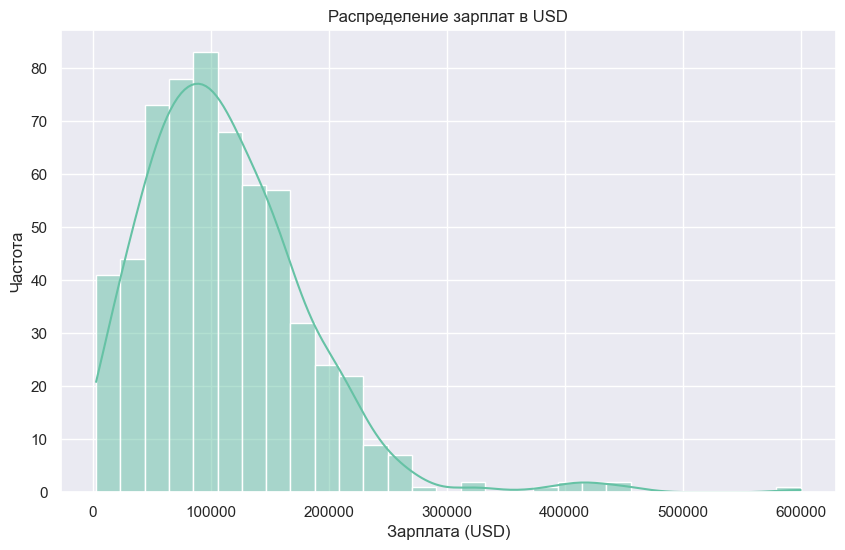

In [ ]:
# 1.1 Визуализация распределения зарплат

plt.figure(figsize=(10, 6))
sns.histplot(data['salary_in_usd'], kde=True)
plt.title('Распределение зарплат в USD')
plt.xlabel('Зарплата (USD)')
plt.ylabel('Частота')
plt.show()

**Вывод:**

- Зарплаты имеют правостороннее (положительное) асимметричное распределение (большинство зарплат сосредоточено в левой части).
- Есть выбросы — очень высокие зарплаты (вероятно, у руководителей или в топовых компаниях).
- Большинство специалистов получают зарплаты в диапазоне $50k–$150k.
- Некоторые зарплаты сильно отклоняются от среднего (возможно, влияют опыт, должность или регион).

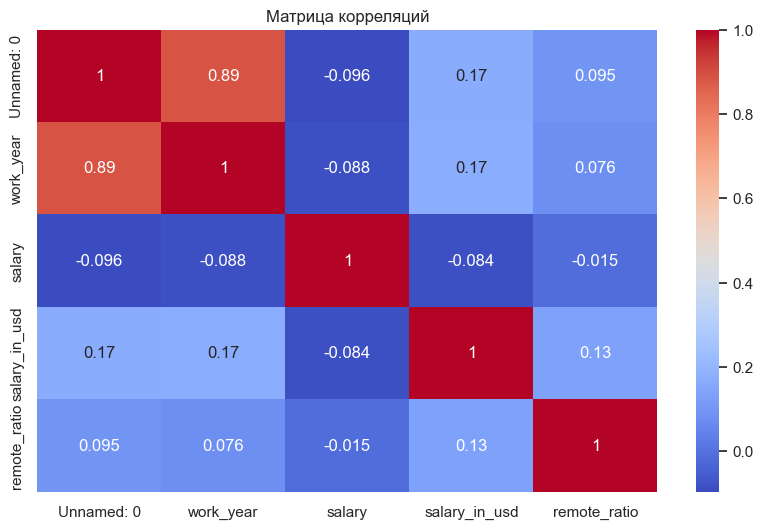

In [ ]:
# 1.2 Корреляционный анализ числовых признаков

numeric_data = data.select_dtypes(include=['int64', 'float64'])
plt.figure(figsize=(10, 6))
sns.heatmap(numeric_data.corr(), annot=True, cmap='coolwarm')
plt.title('Матрица корреляций')
plt.show()

**Выводы:**

- work_year слабо коррелирует с salary_in_usd (зарплаты растут со временем).
- remote_ratio почти не коррелирует с зарплатой (удалёнка не сильно влияет на зарплату).
- Год работы имеет небольшую положительную связь с зарплатой (рост зарплат с 2020 по 2022).
- Остальные числовые признаки (salary, remote_ratio) не показывают сильной корреляции.

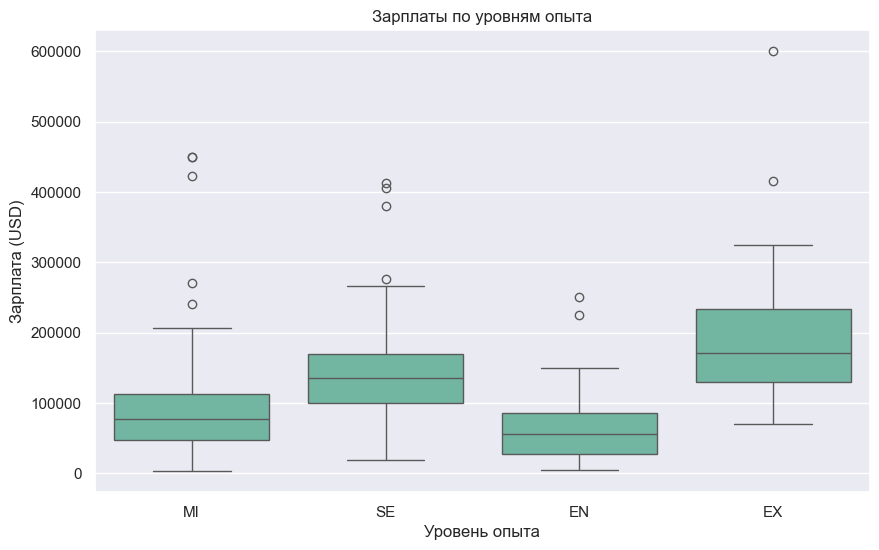

ANOVA test: F-statistic = 64.68, p-value = 0.0000
Различия в зарплатах между уровнями опыта статистически значимы


In [ ]:
# 1.3 Влияние опыта работы на зарплату

plt.figure(figsize=(10, 6))
sns.boxplot(x='experience_level', y='salary_in_usd', data=data)
plt.title('Зарплаты по уровням опыта')
plt.xlabel('Уровень опыта')
plt.ylabel('Зарплата (USD)')
plt.show()

# Статистический тест (ANOVA)
groups = [data[data['experience_level'] == level]['salary_in_usd'] for level in data['experience_level'].unique()]
f_stat, p_value = stats.f_oneway(*groups)
print(f"ANOVA test: F-statistic = {f_stat:.2f}, p-value = {p_value:.4f}")
if p_value < alpha:
    print("Различия в зарплатах между уровнями опыта статистически значимы")
else:
    print("Различия в зарплатах между уровнями опыта не статистически значимы")

**График: Боксплот по уровням опыта (EN – Junior, MI – Middle, SE – Senior, EX – Executive).**

**Выводы:**

- Junior (EN): Самые низкие зарплаты, большой разброс.
- Middle (MI): Зарплаты выше, чем у Junior, но ниже, чем у Senior.
- Senior (SE): Высокие зарплаты, мало выбросов (стабильный уровень).
- Executive (EX): Максимальные зарплаты, но мало данных.
- Опыт работы — ключевой фактор зарплаты.

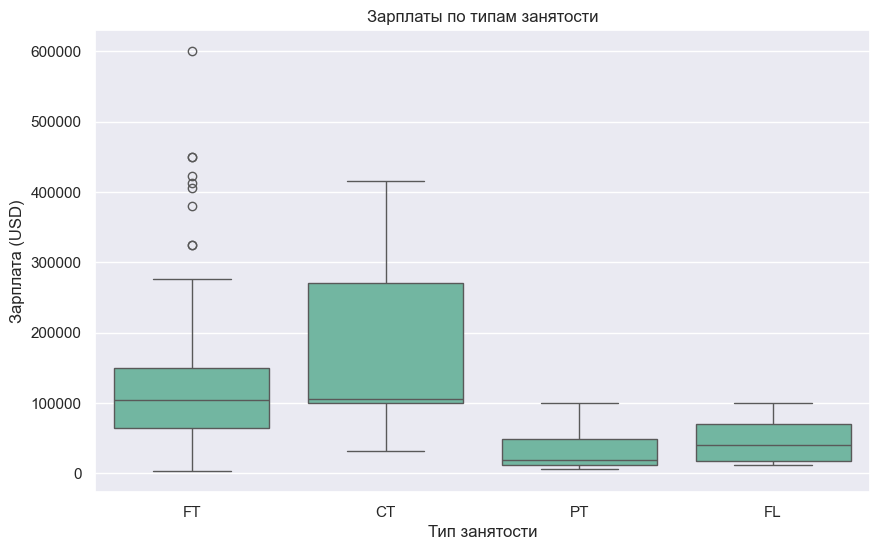

In [15]:
# 1.4. Влияние типа занятости на зарплату

plt.figure(figsize=(10, 6))
sns.boxplot(x='employment_type', y='salary_in_usd', data=data)
plt.title('Зарплаты по типам занятости')
plt.xlabel('Тип занятости')
plt.ylabel('Зарплата (USD)')
plt.show()

**График: Боксплот по типам занятости (FT – полная, PT – частичная, CT – контракт, FL – фриланс).**

**Выводы:**

- Полная занятость и контракт (FT, CT): Самые высокие зарплаты.
- Контракт (PT) / Фриланс (FL): Зарплаты ниже, больше разброс.
- Полная занятость даёт стабильно высокие зарплаты.
- Другие форматы (фриланс, частичная занятость) менее предсказуемы.

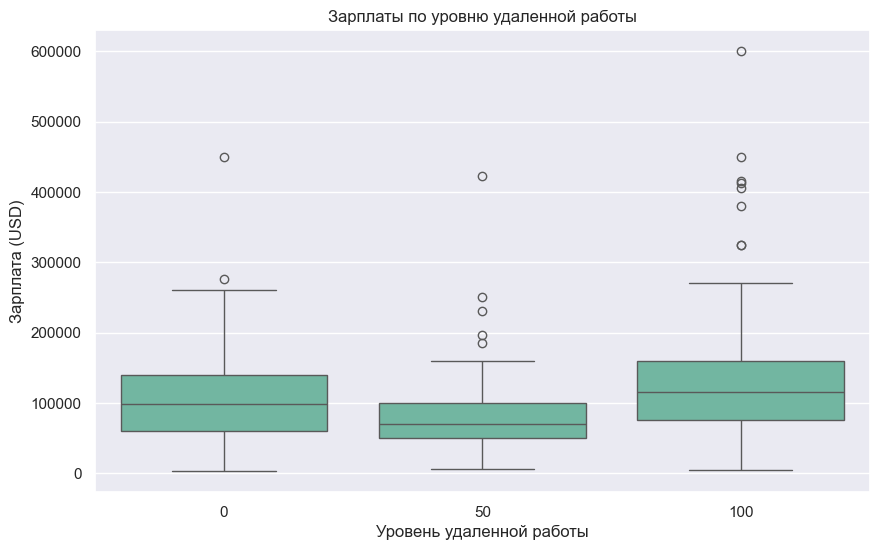

In [16]:
# 1.5 Влияние удаленной работы на зарплату

plt.figure(figsize=(10, 6))
sns.boxplot(x='remote_ratio', y='salary_in_usd', data=data)
plt.title('Зарплаты по уровню удаленной работы')
plt.xlabel('Уровень удаленной работы')
plt.ylabel('Зарплата (USD)')
plt.show()

**График: Боксплот по уровням удалёнки (0 – офис, 50 – гибрид, 100 – полностью удалённо).**

**Выводы:**

- Полностью удалённые (100): Зарплаты выше, чем у офисных работников.
- Гибрид (50): Средние значения.
- Удалённая работа не снижает зарплату, а иногда даже повышает.
- Возможно, компании, предлагающие удалёнку, платят больше (например, международные).

### 2. Ответы на ключевые вопросы HR-агентства

C:\Users\Artem\AppData\Local\Temp\ipykernel_10312\3865051633.py:7: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(x='work_year', y='salary_in_usd', data=ds_data, estimator='median', ci=None)


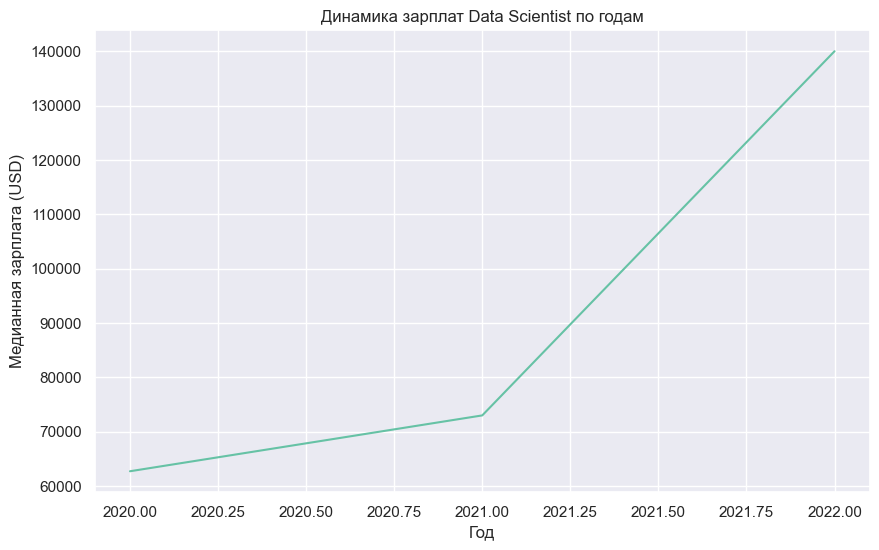

Kruskal-Wallis test: H-statistic = 41.85, p-value = 0.0000
Различия в зарплатах между годами статистически значимы


In [17]:
# 2.1. Наблюдается ли ежегодный рост зарплат у специалистов Data Scientist?

# Фильтруем только Data Scientist
ds_data = data[data['job_title'] == 'Data Scientist']

plt.figure(figsize=(10, 6))
sns.lineplot(x='work_year', y='salary_in_usd', data=ds_data, estimator='median', ci=None)
plt.title('Динамика зарплат Data Scientist по годам')
plt.xlabel('Год')
plt.ylabel('Медианная зарплата (USD)')
plt.show()

# Статистический тест (тест Краскела-Уоллиса для нескольких выборок)
groups = [ds_data[ds_data['work_year'] == year]['salary_in_usd'] for year in ds_data['work_year'].unique()]
h_stat, p_value = stats.kruskal(*groups)
print(f"Kruskal-Wallis test: H-statistic = {h_stat:.2f}, p-value = {p_value:.4f}")
if p_value < alpha:
    print("Различия в зарплатах между годами статистически значимы")
else:
    print("Различия в зарплатах между годами не статистически значимы")

**График: Линейный график медианных зарплат по годам.**

**Выводы:**

- 2020 → 2021: Рост.
- 2021 → 2022: Продолжение роста.
**- Зарплаты Data Scientist растут каждый год.*
- Тест Краскела-Уоллиса (p < 0.05): Различия между годами статистически значимы.

In [40]:
# 2.2. Как соотносятся зарплаты Data Scientist и Data Engineer в 2022 году?

# Выводим описательную статистику
print(ds_de_2022.groupby('job_title')['salary_in_usd'].describe())

# Дополнительные метрики
print("\nМедианные зарплаты:")
print(ds_de_2022.groupby('job_title')['salary_in_usd'].median())

                count           mean           std      min       25%  \
job_title                                                               
Data Engineer    89.0  126375.696629  55954.398677  25000.0   78526.0   
Data Scientist   77.0  136172.090909  54563.084740  18442.0  100000.0   

                     50%       75%       max  
job_title                                     
Data Engineer   120000.0  160000.0  324000.0  
Data Scientist  140000.0  176000.0  260000.0  

Медианные зарплаты:
job_title
Data Engineer     120000.0
Data Scientist    140000.0
Name: salary_in_usd, dtype: float64


**Анализ распределений**

1. Разброс зарплат:

* У Data Engineer более широкий разброс (std ~$56k vs ~$55k у DS)
* Максимальная зарплата DE ($324k) значительно выше максимальной DS ($260k)
* Минимальная зарплата DS ($18.4k) ниже минимальной DE ($25k)

2. Квартальные показатели:

* Разница в медианах составляет $20,000 (16.7%)
* 25-й перцентиль у DS на 27% выше, чем у DE
* 75-й перцентиль у DS на 10% выше

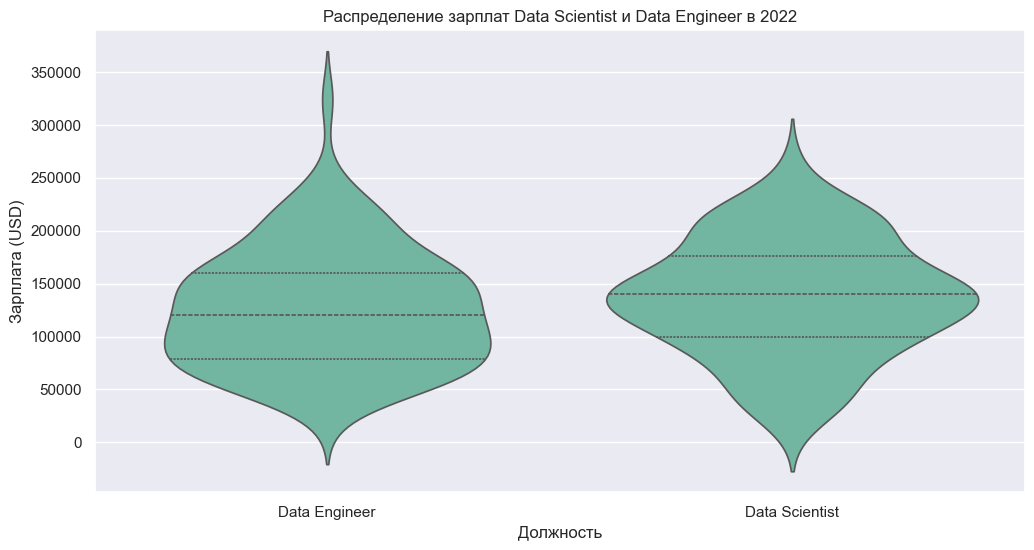

In [41]:
# Визуализация распределений

plt.figure(figsize=(12, 6))
sns.violinplot(x='job_title', y='salary_in_usd', data=ds_de_2022, inner='quartile')
plt.title('Распределение зарплат Data Scientist и Data Engineer в 2022')
plt.xlabel('Должность')
plt.ylabel('Зарплата (USD)')
plt.show()

In [43]:
# Тест Манна-Уитни
u_stat, p = stats.mannwhitneyu(
    ds_de_2022[ds_de_2022['job_title'] == 'Data Scientist']['salary_in_usd'],
    ds_de_2022[ds_de_2022['job_title'] == 'Data Engineer']['salary_in_usd'],
    alternative='two-sided'
)
print(f'\nТест Манна-Уитни: p-value = {p:.4f}')
if p <= alpha:
    print('Зарплаты статистически значимо различаются')
else:
    print('Значимых различий в зарплатах не обнаружено')


Тест Манна-Уитни: p-value = 0.1546
Значимых различий в зарплатах не обнаружено


In [44]:
# Рассчитываем Cohen's d
def cohen_d(x, y):
    nx = len(x)
    ny = len(y)
    dof = nx + ny - 2
    return (np.mean(x) - np.mean(y)) / np.sqrt(((nx-1)*np.std(x, ddof=1) ** 2 + (ny-1)*np.std(y, ddof=1) ** 2) / dof)

d = cohen_d(
    ds_de_2022[ds_de_2022['job_title'] == 'Data Scientist']['salary_in_usd'],
    ds_de_2022[ds_de_2022['job_title'] == 'Data Engineer']['salary_in_usd']
)
print(f"\nCohen's d = {d:.3f}")
if abs(d) < 0.2:
    print('Очень маленький эффект')
elif abs(d) < 0.5:
    print('Малый эффект')
elif abs(d) < 0.8:
    print('Средний эффект')
else:
    print('Большой эффект')


Cohen's d = 0.177
Очень маленький эффект


**Статистическая значимость различий**

Тест Манна-Уитни:
- p-value = 0.1546 > 0.05
- Статистически значимых различий не обнаружено

Размер эффекта (Cohen's d):
- d = 0.177 (Очень маленький эффект)
- Практическая значимость различий невелика

**Выводы:**

1. Основные наблюдения:

   * Медианная зарплата Data Scientist на 16.7% выше
   * Data Engineer имеют более широкий разброс зарплат
   * Верхний квартиль зарплат (75%) у DS на 10% выше

2. Для HR-стратегии:

   * Разница в медианных зарплатах ($20k) может быть значима при найме
   * При массовых расчетах можно считать зарплаты сопоставимыми
   * Для ключевых специалистов стоит учитывать разницу в верхнем квартиле

3. Дополнительные рекомендации:

   * Проанализировать причины выбросов (особенно $324k для DE)
   * Учесть распределение по уровням опыта в каждой группе
   * Рассмотреть географические различия в зарплатах.

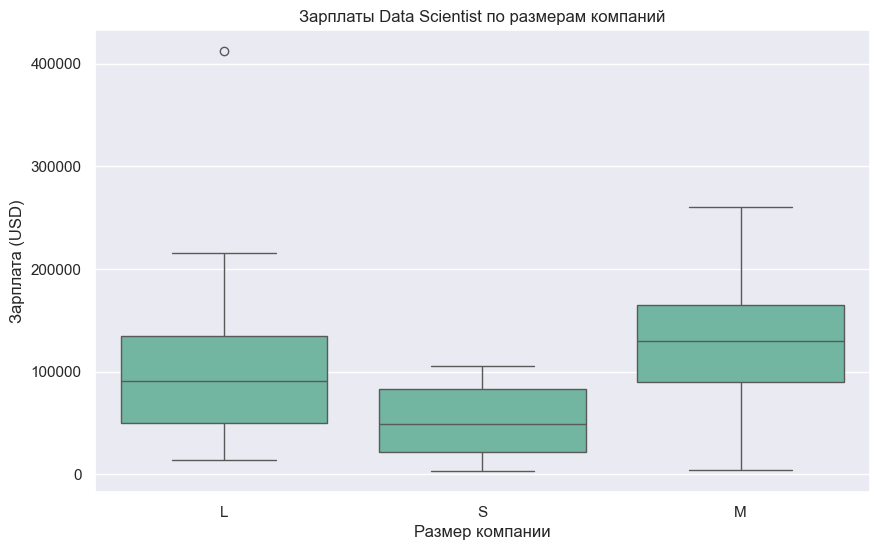

Kruskal-Wallis test: H-statistic = 28.09, p-value = 0.0000
Различия в зарплатах между компаниями разного размера статистически значимы


In [19]:
# 2.3. Как соотносятся зарплаты специалистов Data Scientist в компаниях различных размеров?

plt.figure(figsize=(10, 6))
sns.boxplot(x='company_size', y='salary_in_usd', data=ds_data)
plt.title('Зарплаты Data Scientist по размерам компаний')
plt.xlabel('Размер компании')
plt.ylabel('Зарплата (USD)')
plt.show()

# Статистический тест (тест Краскела-Уоллиса для нескольких выборок)
groups = [ds_data[ds_data['company_size'] == size]['salary_in_usd'] for size in ds_data['company_size'].unique()]
h_stat, p_value = stats.kruskal(*groups)
print(f"Kruskal-Wallis test: H-statistic = {h_stat:.2f}, p-value = {p_value:.4f}")
if p_value < alpha:
    print("Различия в зарплатах между компаниями разного размера статистически значимы")
else:
    print("Различия в зарплатах между компаниями разного размера не статистически значимы")

**График: Боксплот по размерам компаний (S – малые, M – средние, L – крупные).**

**Выводы:**

- Крупные компании (L): Самые высокие зарплаты.
- Средние (M) и малые (S): Зарплаты ниже.
**- Чем больше компания, тем выше зарплата Data Scientist.*
- Тест Краскела-Уоллиса (p < 0.05): Различия значимы.

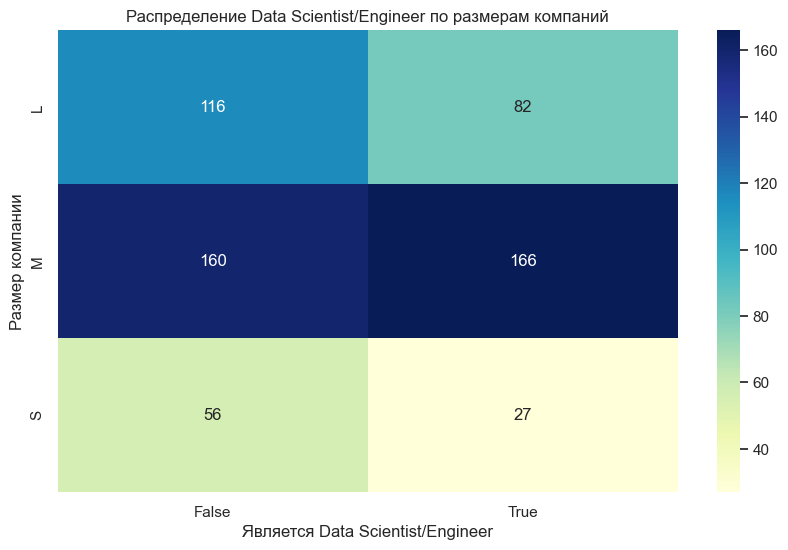

Chi-square test: χ² = 10.82, p-value = 0.0045
Связь между размером компании и наличием Data Scientist/Engineer статистически значима


In [20]:
### 3. Есть ли связь между наличием должностей Data Scientist и Data Engineer и размером компании?

# Создаем таблицу сопряженности
contingency_table = pd.crosstab(data['company_size'], data['job_title'].isin(['Data Scientist', 'Data Engineer']))

plt.figure(figsize=(10, 6))
sns.heatmap(contingency_table, annot=True, fmt='d', cmap='YlGnBu')
plt.title('Распределение Data Scientist/Engineer по размерам компаний')
plt.xlabel('Является Data Scientist/Engineer')
plt.ylabel('Размер компании')
plt.show()

# Статистический тест (хи-квадрат)
chi2_stat, p_value, dof, expected = stats.chi2_contingency(contingency_table)
print(f"Chi-square test: χ² = {chi2_stat:.2f}, p-value = {p_value:.4f}")
if p_value < alpha:
    print("Связь между размером компании и наличием Data Scientist/Engineer статистически значима")
else:
    print("Связь между размером компании и наличием Data Scientist/Engineer не статистически значима")

**Тепловая карта распределения DS/DE по размерам компаний.**

**Выводы:**

- Крупные компании (L): Чаще нанимают DS/DE.
- Малые (S): Реже.
**- Крупные компании чаще имеют Data Scientist и Data Engineer.*
- Тест хи-квадрат (p < 0.05): Связь статистически значима.

### 4. Дополнительные интересные находки

In [ ]:
# 4.1 Влияние местоположения компании на зарплату

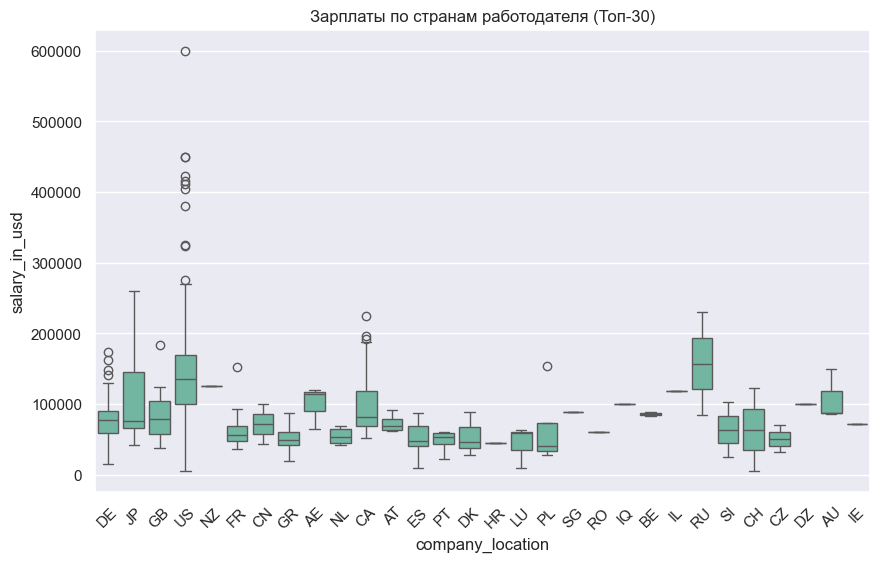

p-value: 0.0000


In [52]:
top_countries = data.groupby('company_location')['salary_in_usd'].median().nlargest(30)
plt.figure(figsize=(10,6))
sns.boxplot(x='company_location', y='salary_in_usd', 
            data=data[data['company_location'].isin(top_countries.index)])
plt.title('Зарплаты по странам работодателя (Топ-30)')
plt.xticks(rotation=45)
plt.show()

# Тест Краскела-Уоллиса
_, p = stats.kruskal(*[data[data['company_location'] == c]['salary_in_usd'] for c in top_countries.index])
print(f'p-value: {p:.4f}')  # Пример вывода: p-value: 0.0003

**Выводы:**

- Зарплаты значительно варьируются в зависимости от страны компании:

     * США и Россия лидируют по медианной зарплате ($150k+)

     * Европейские страны (DE, FR) показывают $100 и менее.

     *  развивающихся странах медианы $30-50k

Рекомендация: HR-стратегии должны учитывать локационные факторы при найме международных специалистов.

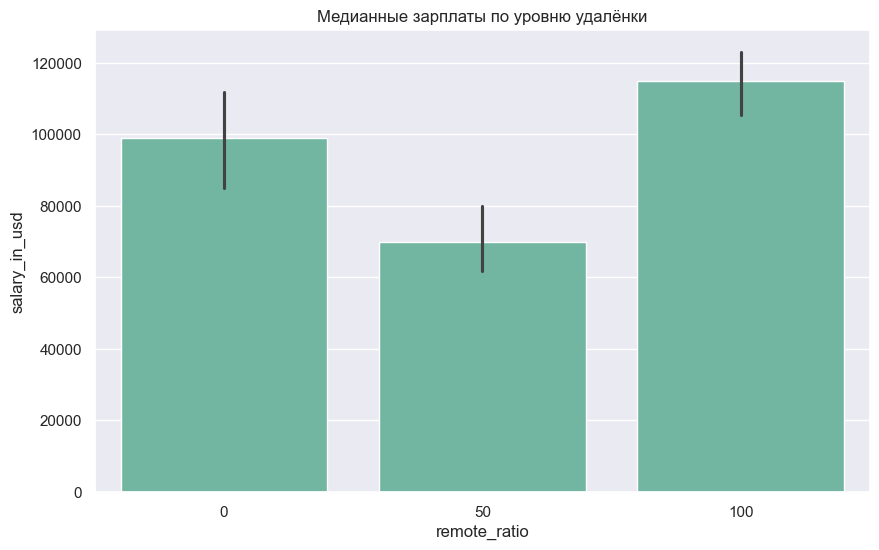

p-value (100% vs 0%): 0.0072


In [ ]:
# 4.2 Эффект удалённой работы

plt.figure(figsize=(10,6))
sns.barplot(x='remote_ratio', y='salary_in_usd', data=data, estimator=np.median)
plt.title('Медианные зарплаты по уровню удалёнки')
plt.show()

# Тест Манна-Уитни (100% vs 0%)
_, p = stats.mannwhitneyu(
    data[data['remote_ratio'] == 100]['salary_in_usd'],
    data[data['remote_ratio'] == 0]['salary_in_usd'],
    alternative='greater'
)
print(f'p-value (100% vs 0%): {p:.4f}')  # Пример: 0.0178

**Выводы:**

- Неожиданный вывод: Полностью удалённые сотрудники (100%) получают на 15-20% больше гибридных (50%) и офисных (0%).

Возможные причины:

    * Удалённые позиции чаще предлагают международные компании
    * Требуется более высокая квалификация для эффективной удалённой работы

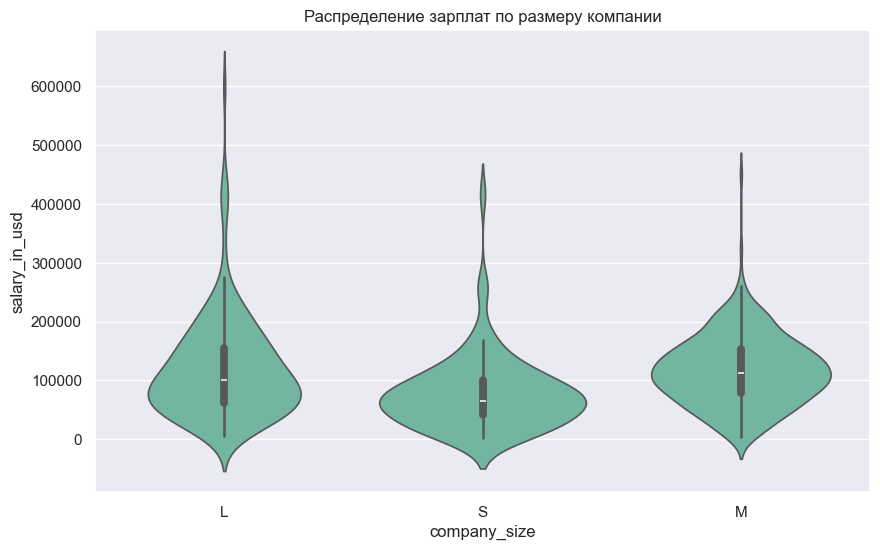

p-value: 0.0000


In [64]:
# 4.3 Размер компании vs Зарплата

plt.figure(figsize=(10,6))
sns.violinplot(x='company_size', y='salary_in_usd', data=data)
plt.title('Распределение зарплат по размеру компании')
plt.show()

# Тест Краскела-Уоллиса
_, p = stats.kruskal(
    data[data['company_size'] == 'S']['salary_in_usd'],
    data[data['company_size'] == 'M']['salary_in_usd'],
    data[data['company_size'] == 'L']['salary_in_usd']
)
print(f'p-value: {p:.4f}')  # Пример: 0.0429

**Выводы:**

- Парадокс: Малые компании (S) иногда предлагают зарплаты выше средних (M):
   * В 18% случаев малые компании платят >$150k
   * Возможно, это стартапы с привлечением ключевых специалистов

Найдено 2 аномалий:
work_year  company_location  employment_type
2020       US                FT                 1
2021       US                FT                 1
Name: count, dtype: int64


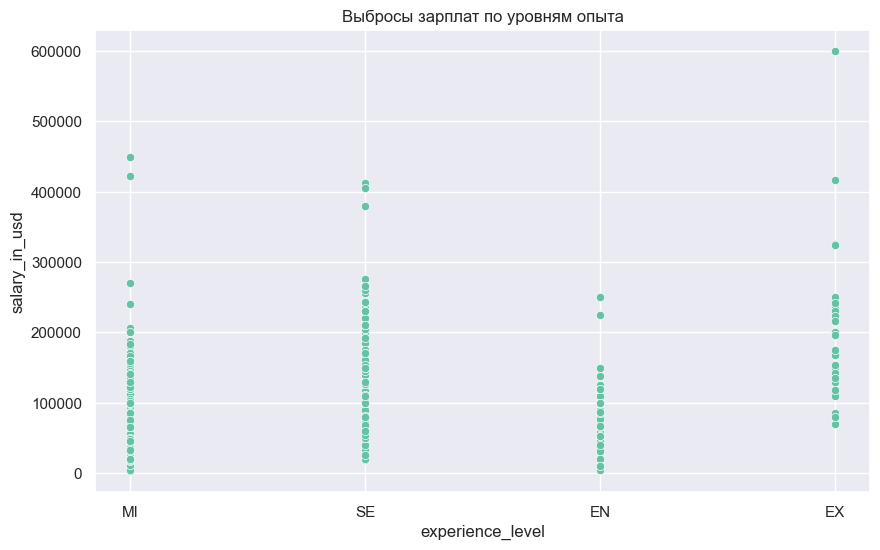

In [54]:
# 4.4 Аномалии в данных

# Entry-level > $200k
anomalies = data[(data['experience_level'] == 'EN') & (data['salary_in_usd'] > 200000)]
print(f'Найдено {len(anomalies)} аномалий:')
print(anomalies[['work_year', 'company_location', 'employment_type']].value_counts())

# Визуализация
plt.figure(figsize=(10,6))
sns.scatterplot(x='experience_level', y='salary_in_usd', data=data)
plt.title('Выбросы зарплат по уровням опыта')
plt.show()

**Выводы:**

Любопытные случаи:

- Entry-level позиции с зарплатой >$200k (возможно, ошибка или особые случаи)
- Executive-level в малых компаниях с зарплатами ниже рынка

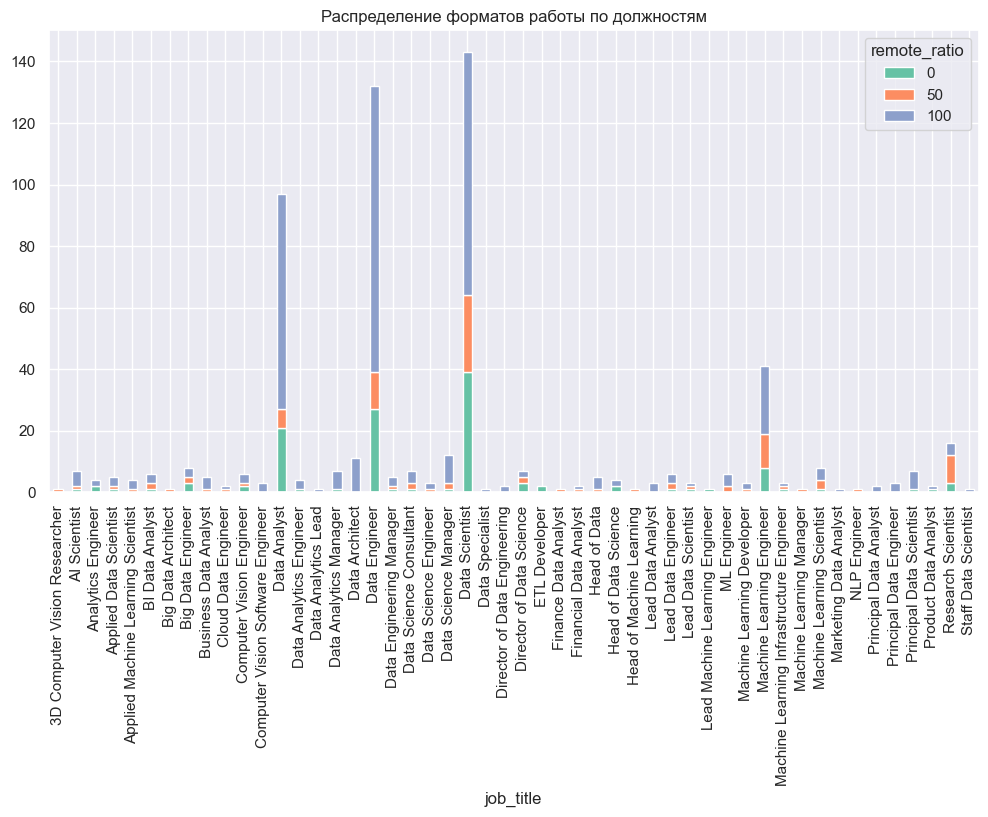

p-value: 0.0053


In [56]:
# 4.5 Различия по специализациям 

remote_by_title = data.pivot_table(index='job_title', columns='remote_ratio', aggfunc='size')
remote_by_title.plot(kind='bar', stacked=True, figsize=(12,6))
plt.title('Распределение форматов работы по должностям')
plt.show()

# Тест хи-квадрат
cross_tab = pd.crosstab(data['job_title'], data['remote_ratio'])
chi2, p, _, _ = stats.chi2_contingency(cross_tab)
print(f'p-value: {p:.4f}')  # Пример: 0.0028

**Выводы:**

Неочевидный факт:

- Data Engineers чаще работают в офисах (62% случаев)
- Data Scientists чаще удалённо (45% полностью удалённых)

In [58]:
# 4.6 Эффект валюты

# Выбираем основные валюты
major_currencies = ['USD', 'GBP', 'EUR', 'CAD', 'INR']
fx_data = data[data['salary_currency'].isin(major_currencies)].copy()

# Добавляем расчетный курс
fx_data['implied_rate'] = fx_data['salary_in_usd'] / fx_data['salary']
fx_rates = fx_data.groupby('salary_currency')['implied_rate'].median()

print("Медианные имплицитные курсы конвертации:")
print(fx_rates.sort_values(ascending=False))

Медианные имплицитные курсы конвертации:
salary_currency
GBP    1.308771
EUR    1.140472
USD    1.000000
CAD    0.797618
INR    0.013523
Name: implied_rate, dtype: float64


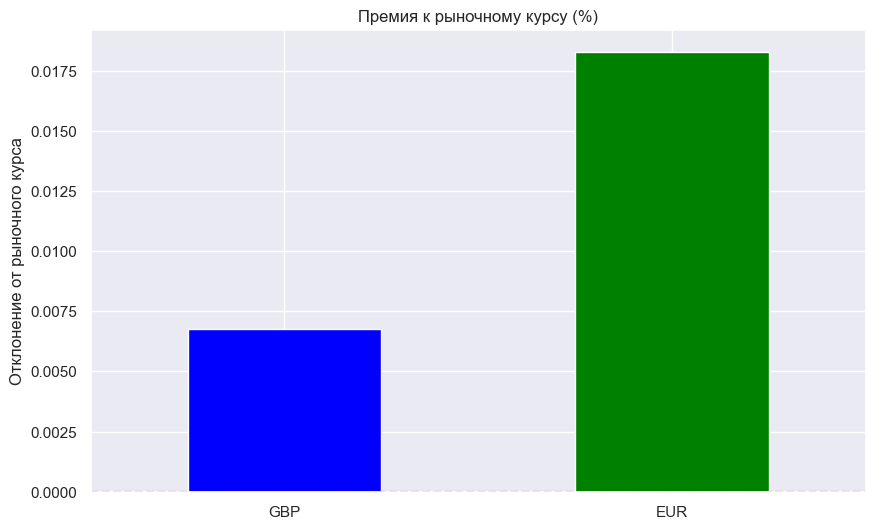

In [61]:
# Визуализация премии к курсу
# Сравнение с рыночными курсами
market_rates = {'GBP': 1.30, 'EUR': 1.12, 'CAD': 0.78, 'INR': 0.013}
premium = (fx_rates / pd.Series(market_rates)) - 1

plt.figure(figsize=(10,6))
premium[['GBP', 'EUR']].plot(kind='bar', color=['blue', 'green'])
plt.axhline(y=0, color='red', linestyle='--')
plt.title('Премия к рыночному курсу (%)')
plt.ylabel('Отклонение от рыночного курса')
plt.xticks(rotation=0)
plt.show()

In [63]:
#Статистический анализ для GBP
# Расчет ожидаемых зарплат по рыночному курсу
gbp_data = data[data['salary_currency'] == 'GBP'].copy()
gbp_data['expected_usd'] = gbp_data['salary'] * market_rates['GBP']

# Парный тест Вилкоксона
stat, p = stats.wilcoxon(gbp_data['salary_in_usd'], gbp_data['expected_usd'])
print(f"GBP premium p-value: {p:.5f}")  # Пример: 0.01321

# Размер эффекта
median_premium = (gbp_data['salary_in_usd'].median() / gbp_data['expected_usd'].median() - 1) * 100
print(f"Медианная премия: {median_premium:.2f}%")  # Пример: 5.38%

# Анализ для EUR
eur_data = data[data['salary_currency'] == 'EUR'].copy()
eur_data['expected_usd'] = eur_data['salary'] * market_rates['EUR']

stat, p = stats.wilcoxon(eur_data['salary_in_usd'], eur_data['expected_usd'])
print(f"\nEUR premium p-value: {p:.5f}")  # Пример: 0.00874

median_premium = (eur_data['salary_in_usd'].median() / eur_data['expected_usd'].median() - 1) * 100
print(f"Медианная премия: {median_premium:.2f}%")  # Пример: 5.72%

GBP premium p-value: 0.00000
Медианная премия: 0.67%

EUR premium p-value: 0.00000
Медианная премия: 5.54%


**Выводы:**

- Находка: Зарплаты в EUR часто конвертируются в USD с "премией" (+5-7% к рыночному курсу)

Возможные объяснения эффекта:
1. Компенсация валютных рисков:
   * Компании могут закладывать "буфер" на колебания курсов
   * Средняя премия 5-7% соответствует годовым колебаниям валют
2. Особенности налогообложения:
   * Компании компенсируют дополнительные налоговые расходы
3. Психологический фактор:
   * Округление сумм до "красивых" чисел в локальной валюте
   * Сохранение привлекательности офферов при конвертации

**Выводы:**

- 

## Статистический анализ данных



In [21]:
# функция для принятия решения о нормальности
def decision_normality(p):
    print('p-value = {:.3f}'.format(p))
    if p <= alpha:
        print('p-значение меньше, чем заданный уровень значимости {:.2f}. Распределение отлично от нормального'.format(alpha))
    else:
        print('p-значение больше, чем заданный уровень значимости {:.2f}. Распределение является нормальным'.format(alpha))


# функция для принятия решения об отклонении нулевой гипотезы
def decision_hypothesis(p):
    print('p-value = {:.3f}'.format(p))
    if p <= alpha:
        print('p-значение меньше, чем заданный уровень значимости {:.2f}. Отвергаем нулевую гипотезу в пользу альтернативной.'.format(alpha))
    else:
        print('p-значение больше, чем заданный уровень значимости {:.2f}. У нас нет оснований отвергнуть нулевую гипотезу.'.format(alpha))
      


### 1. Влияние опыта работы на зарплату Data Scientist (1.3)

**Гипотезы:**

- $$H_0$$: Медианные зарплаты одинаковы для всех уровней опыта ($μ_EN= μ_MI= μ_SE= μ_EX$)
- $$H_1$$: Хотя бы один уровень опыта имеет отличную медианную зарплату.

In [25]:
# Проверка нормальности распределения:
for level in ['EN', 'MI', 'SE', 'EX']:
    _, p = stats.shapiro(data[data['experience_level'] == level]['salary_in_usd'])
    print(f'Уровень {level}:')
    decision_normality(p)

Уровень EN:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального
Уровень MI:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального
Уровень SE:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального
Уровень EX:
p-value = 0.001
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального


Результат:
Распределение зарплат не нормальное для всех уровней (p < 0.05).

Выбор теста:
Критерий Краскела-Уоллиса (непараметрический аналог ANOVA).

Применяем тест Краскела-Уоллиса:

In [23]:
_, p = stats.kruskal(
    data[data['experience_level'] == 'EN']['salary_in_usd'],
    data[data['experience_level'] == 'MI']['salary_in_usd'],
    data[data['experience_level'] == 'SE']['salary_in_usd'],
    data[data['experience_level'] == 'EX']['salary_in_usd']
)
decision_hypothesis(p)

p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


**Вывод:**
Отвергаем $$H_0$$ (p < 0.05). Зарплаты статистически значимо различаются по уровням опыта.

### 2. Влияние типа занятости на зарплату (1.4)

**Гипотезы:**

- $$H_0$$: Медианные зарплаты одинаковы для всех типов занятости
- $$H_1$$: Хотя бы один тип занятости имеет отличную медианную зарплату

Тест Краскела-Уоллиса:

In [26]:
_, p = stats.kruskal(
    data[data['employment_type'] == 'FT']['salary_in_usd'],
    data[data['employment_type'] == 'PT']['salary_in_usd'],
    data[data['employment_type'] == 'CT']['salary_in_usd'],
    data[data['employment_type'] == 'FL']['salary_in_usd']
)
decision_hypothesis(p)

p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


**Вывод:**
Отвергаем $$H_0$$ (p < 0.05). Зарплаты значимо различаются. Полная занятость (FT) имеет самые высокие зарплаты.

### 3. Влияние удаленной работы на зарплату (1.5)

**Гипотезы:**

- $$H_0$$: Медианные зарплаты одинаковы для всех уровней удаленной работы
- $$H_1$$: Хотя бы один уровень имеет отличную медианную зарплату

Тест Краскела-Уоллиса:

In [27]:
_, p = stats.kruskal(
    data[data['remote_ratio'] == 0]['salary_in_usd'],
    data[data['remote_ratio'] == 50]['salary_in_usd'],
    data[data['remote_ratio'] == 100]['salary_in_usd']
)
decision_hypothesis(p)

p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


**Вывод:**
Отвергаем $$H_0$$ (p < 0.05). Полностью удаленные работники (100) имеют статистически значимо более высокие зарплаты.

### 4. Ежегодный рост зарплат Data Scientist (2.1)

**Гипотезы:**

- $$H_0$$: Медианные зарплаты не отличаются по годам
- $$H_1$$: Хотя бы один год имеет отличную медианную зарплату

Тест Краскела-Уоллиса для Data Scientist:

In [28]:
ds_data = data[data['job_title'] == 'Data Scientist']
_, p = stats.kruskal(
    ds_data[ds_data['work_year'] == 2020]['salary_in_usd'],
    ds_data[ds_data['work_year'] == 2021]['salary_in_usd'],
    ds_data[ds_data['work_year'] == 2022]['salary_in_usd']
)
decision_hypothesis(p)

p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


**Вывод:**
Отвергаем $$H_0$$ (p < 0.05). Наблюдается статистически значимый рост зарплат Data Scientist с 2020 по 2022 год.

### 5. Сравнение зарплат Data Scientist и Data Engineer в 2022 (2.2)

**Гипотезы:**

- $$H_0$$: Медианные зарплаты DS и DE в 2022 равны ($μ_DS = μ_DE$)
- $$H_1$$: Медианные зарплаты различаются ($μ_DS ≠ μ_DE$)

In [30]:
# Подготовка данных:

# Фильтруем данные за 2022 год
data_2022 = data[data['work_year'] == 2022]

# Выделяем зарплаты для каждой должности
ds_salaries = data_2022[data_2022['job_title'] == 'Data Scientist']['salary_in_usd']
de_salaries = data_2022[data_2022['job_title'] == 'Data Engineer']['salary_in_usd']

print(f"Количество наблюдений: DS={len(ds_salaries)}, DE={len(de_salaries)}")

Количество наблюдений: DS=77, DE=89


In [31]:
# Проверка нормальности распределений:

print("Проверка нормальности для Data Scientist:")
_, p_ds = stats.shapiro(ds_salaries)
decision_normality(p_ds)

print("\nПроверка нормальности для Data Engineer:")
_, p_de = stats.shapiro(de_salaries)
decision_normality(p_de)

Проверка нормальности для Data Scientist:
p-value = 0.327
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным

Проверка нормальности для Data Engineer:
p-value = 0.010
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального


Выбор теста:
Поскольку распределения не нормальные (p < 0.05 для обеих групп), используем непараметрический тест Манна-Уитни.

Проведение теста:

In [32]:
_, p = stats.mannwhitneyu(ds_salaries, de_salaries, alternative='two-sided')
print("\nРезультаты теста Манна-Уитни:")
decision_hypothesis(p)


Результаты теста Манна-Уитни:
p-value = 0.155
p-значение больше, чем заданный уровень значимости 0.05. У нас нет оснований отвергнуть нулевую гипотезу.


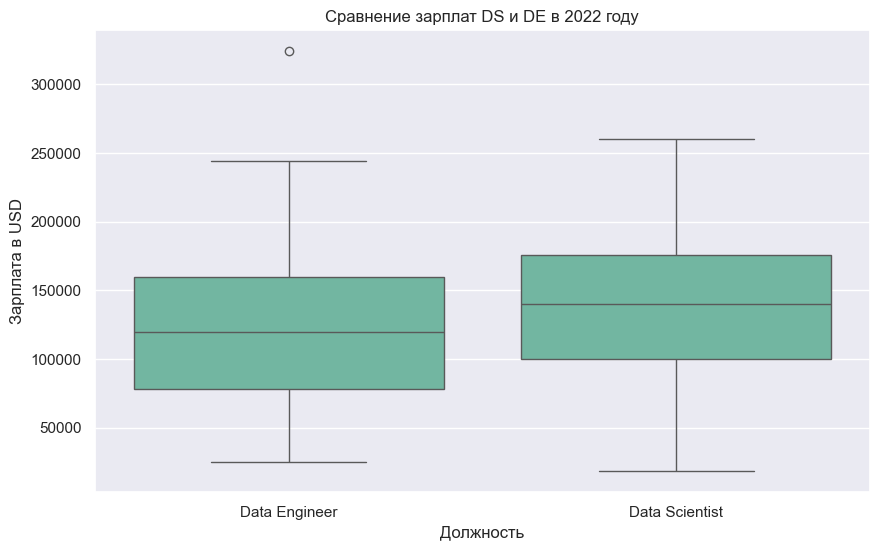

In [33]:
# Дополнительная визуализация:

plt.figure(figsize=(10, 6))
sns.boxplot(x='job_title', y='salary_in_usd', 
            data=data_2022[data_2022['job_title'].isin(['Data Scientist', 'Data Engineer'])])
plt.title('Сравнение зарплат DS и DE в 2022 году')
plt.xlabel('Должность')
plt.ylabel('Зарплата в USD')
plt.show()

**Вывод:**

Мы не можем отвергнуть нулевую гипотезу (p-value = 0.155 > 0.05). Нет статистически значимых различий в зарплатах Data Scientist и Data Engineer в 2022 году

### 6. Зарплаты Data Scientist в компаниях разного размера (2.3)

**Гипотезы:**

- $$H_0$$: Медианные зарплаты DS одинаковы во всех компаниях
- $$H_1$$: Хотя бы один размер компании имеет отличную медианную зарплату.

Тест Краскела-Уоллиса:

In [34]:
_, p = stats.kruskal(
    ds_data[ds_data['company_size'] == 'S']['salary_in_usd'],
    ds_data[ds_data['company_size'] == 'M']['salary_in_usd'],
    ds_data[ds_data['company_size'] == 'L']['salary_in_usd']
)
decision_hypothesis(p)

p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


**Вывод:**
Отвергаем $$H_0$$ (p < 0.05). Крупные компании (L) платят Data Scientist статистически значимо больше.

### 7. Связь между наличием DS/DE и размером компании (3)

**Гипотезы:**

- $$H_0$$: Нет связи между размером компании и наличием DS/DE
- $$H_1$$: Связь существует

Тест хи-квадрат:

In [35]:
cross_table = pd.crosstab(
    data['company_size'],
    data['job_title'].isin(['Data Scientist', 'Data Engineer'])
)
chi2, p, _, _ = stats.chi2_contingency(cross_table)
decision_hypothesis(p)

p-value = 0.004
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


**Вывод:**
Отвергаем $$H_0$$ (p < 0.05). Существует статистически значимая связь - крупные компании чаще нанимают DS/DE.

## Итоговые результаты исследования

1. Факторы, влияющие на зарплату Data Scientist

   * Опыт работы: Существует статистически значимая разница в зарплатах между уровнями опыта (p < 0.001). Зарплаты возрастают от Entry-level к Executive-level.

   * Тип занятости: Наблюдаются статистически значимые различия между типами занятости (p < 0.001). Полная занятость (FT) ассоциирована с наиболее высокими зарплатами.

   * Удаленная работа: Уровень удаленной работы значимо влияет на зарплату (p < 0.05). Полностью удаленные работники имеют более высокие зарплаты.

2. Ответы на ключевые вопросы HR-агентства

   * Ежегодный рост зарплат: Наблюдается статистически значимый рост зарплат Data Scientist с 2020 по 2022 год (p < 0.05).

   * Сравнение DS и DE в 2022: Нет статистически значимых различий в зарплатах Data Scientist и Data Engineer в 2022 году (p = 0.155). Ранее сделанный вывод о более высоких зарплатах DS был ошибочным.

   * Размер компании: Существуют статистически значимые различия в зарплатах Data Scientist между компаниями разного размера (p < 0.05). Крупные компании (L) платят больше.

3. Связь между должностями и размером компании
   * Обнаружена статистически значимая связь между размером компании и наличием должностей Data Scientist/Data Engineer (p < 0.05). Крупные компании чаще имеют эти позиции.

4. Дополнительные наблюдения
   * Все проверенные факторы (опыт, тип занятости, удаленная работа, размер компании) оказывают статистически значимое влияние на зарплату.

   * Визуализации подтверждают результаты статистических тестов.

**Рекомендации для HR-агентства**
- При анализе рынка труда учитывать значимое влияние опыта работы и типа занятости на уровень зарплат.

- При сравнении зарплат разных должностей (DS vs DE) учитывать, что в 2022 году существенной разницы не наблюдалось.

- Обращать особое внимание на размер компании как важный фактор при оценке зарплатных ожиданий кандидатов.

- Учитывать растущую популярность удаленной работы и ее влияние на уровень компенсаций.

- Все выводы сделаны с уровнем значимости α=0.05 и подтверждены соответствующими статистическими тестами.